In [1]:
%load_ext autoreload
%autoreload 2

# Sensitivity peak

The sensitivity has a strange peak at ca. $10^{-3}$. This notebook is investigating that to make sure that it really is just a result of numerical choices.

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sns.histplot = partial(sns.histplot, palette=sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1))
pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


# import umap
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
# from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
# from synbio_morpher.utils.misc.type_handling import flatten_listlike, get_first_elements
# from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.misc.numerical import flatten_to_matrix
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

CONFIG = prepare_config(CONFIG)

## Read in data

In [3]:
# og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'

og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'

fn_og = os.path.join(og_dir, 'circuit_stats.csv')
# mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/mutation_effect_on_interactions_signal'
# fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/summarise_simulation/tabulated_mutation_info.csv'
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'

data = pd.read_csv(fn_mut)

In [4]:
data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)


/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:77: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log = grouped[numerical_cols].apply(


In [5]:
sensitivity_mode = data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')]['sensitivity_wrt_species-6'].value_counts().index[0]

## Load circuits

In [6]:
sens_data = data[data['sensitivity_wrt_species-6'] == sensitivity_mode]
sens_circs = sens_data['circuit_name']
sens_subs = sens_data['mutation_name']
choice_data = data[data['circuit_name'].isin(sens_circs) & data['mutation_name'].isin(list(sens_subs) + ['ref_circuit'])]
choice_data = choice_data[((choice_data['sample_name'] != 'RNA_0') & (choice_data['sensitivity_wrt_species-6'] == sensitivity_mode)
                           ) | (choice_data['sample_name'] == 'RNA_0') | (choice_data['mutation_name'] == 'ref_circuit')]


<AxesSubplot: xlabel='sensitivity_wrt_species-6', ylabel='Count'>

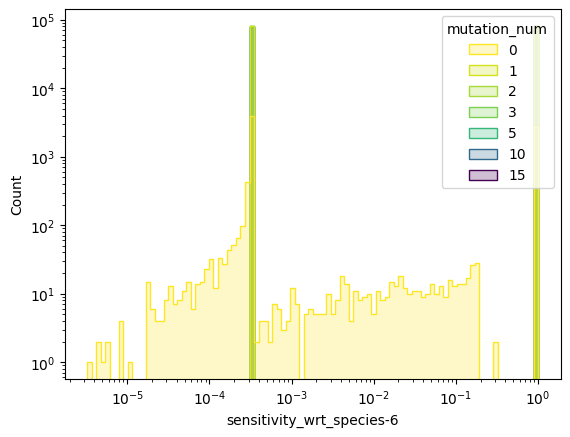

In [7]:
# choice_data[(choice_data['sample_name'] == 'RNA_1')]
# ['sensitivity_wrt_species-6'].value_counts()

sns.histplot(choice_data, x='sensitivity_wrt_species-6', hue='mutation_num', element='step', bins=100, log_scale=[True, True], palette='viridis_r')

In [8]:
def load_circuit(circ_row, config):
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')]),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')]),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')]),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')])}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

nm = 3
circuits = []
num_circuits = 5
for i in range(num_circuits):
    ref_c = choice_data[(choice_data['sample_name'] == 'RNA_1') & (choice_data['mutation_name'] == 'ref_circuit')].iloc[i]
    mut_c = choice_data[(choice_data['sample_name'] == 'RNA_1') & (choice_data['circuit_name'] == ref_c['circuit_name']) & (choice_data['mutation_name'] != 'ref_circuit')].iloc[:nm]
    circuits.append(load_circuit(circ_row=ref_c, config=CONFIG))
    for mi in range(len(mut_c)):
        circuits.append(load_circuit(circ_row=mut_c.iloc[mi], config=CONFIG))
        

forward_rates = circuits[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])


t0 = 0 
t1 = 500
dt = 0.001
tmax = 5000
threshold_steady_states = 0.05

signal_onehot = np.zeros_like(circuits[0].signal.reactions_onehot) if circuits[0].use_prod_and_deg else np.zeros_like(circuits[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits[0].qreactions.reactions.inputs,
                            outputs=circuits[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, int(np.min([200, t1-t0]))))
                            )))


xla_bridge.py:backends():450: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA INFO
xla_bridge.py:backends():450: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():450: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


In [9]:

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)


Done:  0:01:29.625230


In [10]:
signal_species_idx = 6

b_steady_states = b_copynumbers[:, :, -1]
b_steady_states[:, signal_species_idx] += 2 * b_copynumbers[:, signal_species_idx, 0]

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

Done:  0:01:28.261052


Text(0.5, 0.98, 'Circuit traces: reference and mutations')

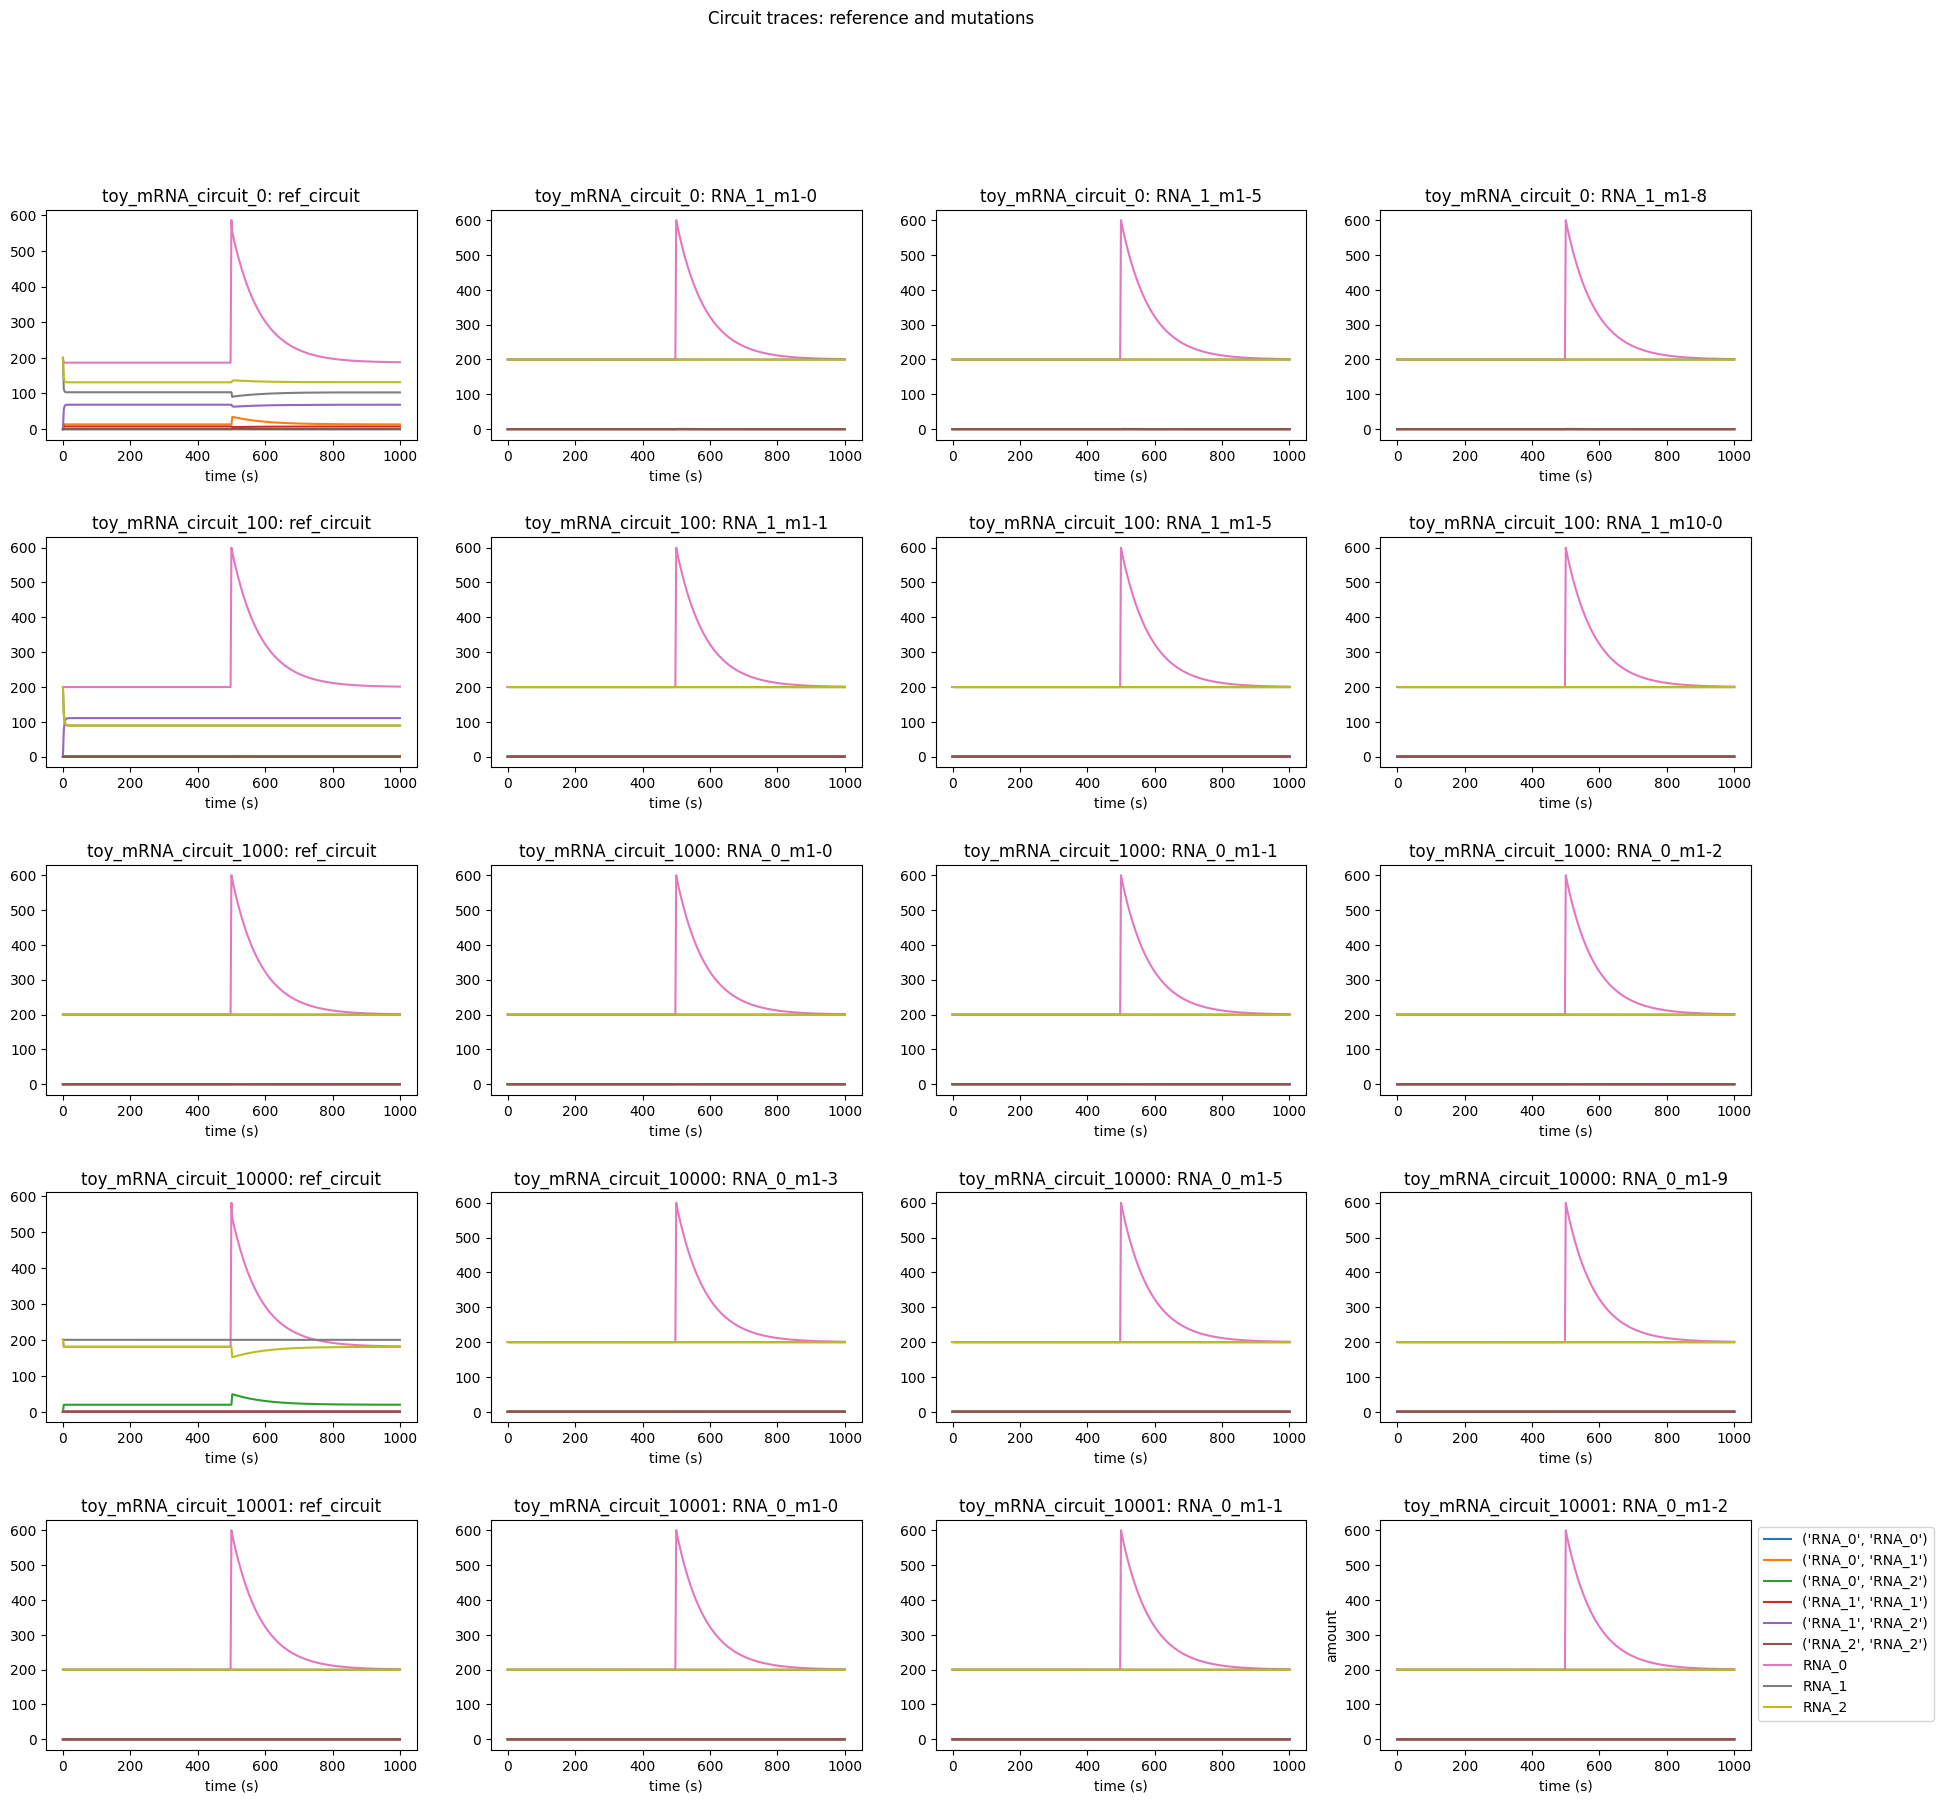

In [11]:
fig = plt.figure(figsize=(22, 20))
fig.subplots_adjust(hspace=0.425)
for i in range(len(circuits)):
    ax = plt.subplot(num_circuits,nm+1,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
    plt.title(f'{circuits[i].name}: {circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
plt.ylabel('amount')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))

plt.suptitle('Circuit traces: reference and mutations')


## Analytics from trace

In [12]:

def append_nest_dicts(l: list, i1: int, d: dict) -> list:
    for i in range(i1):
        b_analytics_k = {}
        for k, v in d.items():
            b_analytics_k[k] = v[i]
        l.append(b_analytics_k)
    return l
b_analytics_l = []
        
ref_idxs = [i for i, x in enumerate([c.subname for c in circuits]) if x == "ref_circuit"]
for ref_idx, ref_idx2 in zip(ref_idxs, ref_idxs[1:] + [len(circuits)]):
    ref_circuit = circuits[ref_idx]
    analytics_func = jax.vmap(partial(
        generate_analytics, time=tyy, labels=[
            s.name for s in ref_circuit.model.species],
        signal_onehot=ref_circuit.signal.onehot, signal_time=1))
    b_analytics = analytics_func(
        data=b_new_copynumbers[ref_idx:ref_idx2])
    
    b_analytics_l = append_nest_dicts(
        b_analytics_l, ref_idx2 - ref_idx, b_analytics)

In [18]:
b_analytics = np.array([b['sensitivity_wrt_species-6'] for b in b_analytics_l])
b_analytics.shape


(20, 9)

In [13]:
# b_analytics = b_analytics_l[0]['sensitivity_wrt_species-6']
# for b in b_analytics_l[1:]:
#     b_analytics = np.concatenate([b_analytics, b['sensitivity_wrt_species-6']], axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [19]:
np.sum((b_analytics > sensitivity_mode - 0.01) | (b_analytics < sensitivity_mode + 0.01))

180

In [20]:
data[data['sensitivity_wrt_species-6'] == sensitivity_mode]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,name,interacting,self_interacting,...,sp_distance_logm,binding_sites_groups_0-0_logm,binding_sites_groups_0-1_logm,binding_sites_groups_0-2_logm,binding_sites_groups_1-0_logm,binding_sites_groups_1-1_logm,binding_sites_groups_1-2_logm,binding_sites_groups_2-0_logm,binding_sites_groups_2-1_logm,binding_sites_groups_2-2_logm
184,toy_mRNA_circuit_0,RNA_1_m1-0,1,[4],[5],data/ensemble_mutation_effect_analysis/2023_07...,60.0,toy_mRNA_circuit_0,[],[],...,0.999667,0,0,0,0,0,0,0,0,0
185,toy_mRNA_circuit_0,RNA_1_m1-0,1,[4],[5],data/ensemble_mutation_effect_analysis/2023_07...,60.0,toy_mRNA_circuit_0,[],[],...,0.999667,0,0,0,0,0,0,0,0,0
199,toy_mRNA_circuit_0,RNA_1_m1-5,1,[7],[4],data/ensemble_mutation_effect_analysis/2023_07...,65.0,toy_mRNA_circuit_0,[],[],...,0.999667,0,0,0,0,0,0,0,0,0
200,toy_mRNA_circuit_0,RNA_1_m1-5,1,[7],[4],data/ensemble_mutation_effect_analysis/2023_07...,65.0,toy_mRNA_circuit_0,[],[],...,0.999667,0,0,0,0,0,0,0,0,0
208,toy_mRNA_circuit_0,RNA_1_m1-8,1,[3],[5],data/ensemble_mutation_effect_analysis/2023_07...,68.0,toy_mRNA_circuit_0,[],[],...,0.999667,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628993,toy_mRNA_circuit_12699,RNA_2_m5-7,5,"[7, 4, 2, 4, 0]","[17, 5, 18, 7, 4]",data/ensemble_mutation_effect_analysis/2023_07...,157.0,toy_mRNA_circuit_12699,[],[],...,0.999667,0,0,0,0,0,0,0,0,0
1628995,toy_mRNA_circuit_12699,RNA_2_m5-8,5,"[4, 0, 5, 5, 6]","[8, 4, 13, 2, 6]",data/ensemble_mutation_effect_analysis/2023_07...,158.0,toy_mRNA_circuit_12699,[],[],...,0.999667,0,0,0,0,0,0,0,0,0
1628996,toy_mRNA_circuit_12699,RNA_2_m5-8,5,"[4, 0, 5, 5, 6]","[8, 4, 13, 2, 6]",data/ensemble_mutation_effect_analysis/2023_07...,158.0,toy_mRNA_circuit_12699,[],[],...,0.999667,0,0,0,0,0,0,0,0,0
1628998,toy_mRNA_circuit_12699,RNA_2_m5-9,5,"[6, 3, 6, 5, 0]","[0, 7, 3, 2, 18]",data/ensemble_mutation_effect_analysis/2023_07...,159.0,toy_mRNA_circuit_12699,[],[],...,0.999667,0,0,0,0,0,0,0,0,0


Text(0.5, 0.98, 'Initial and steady states distributions')

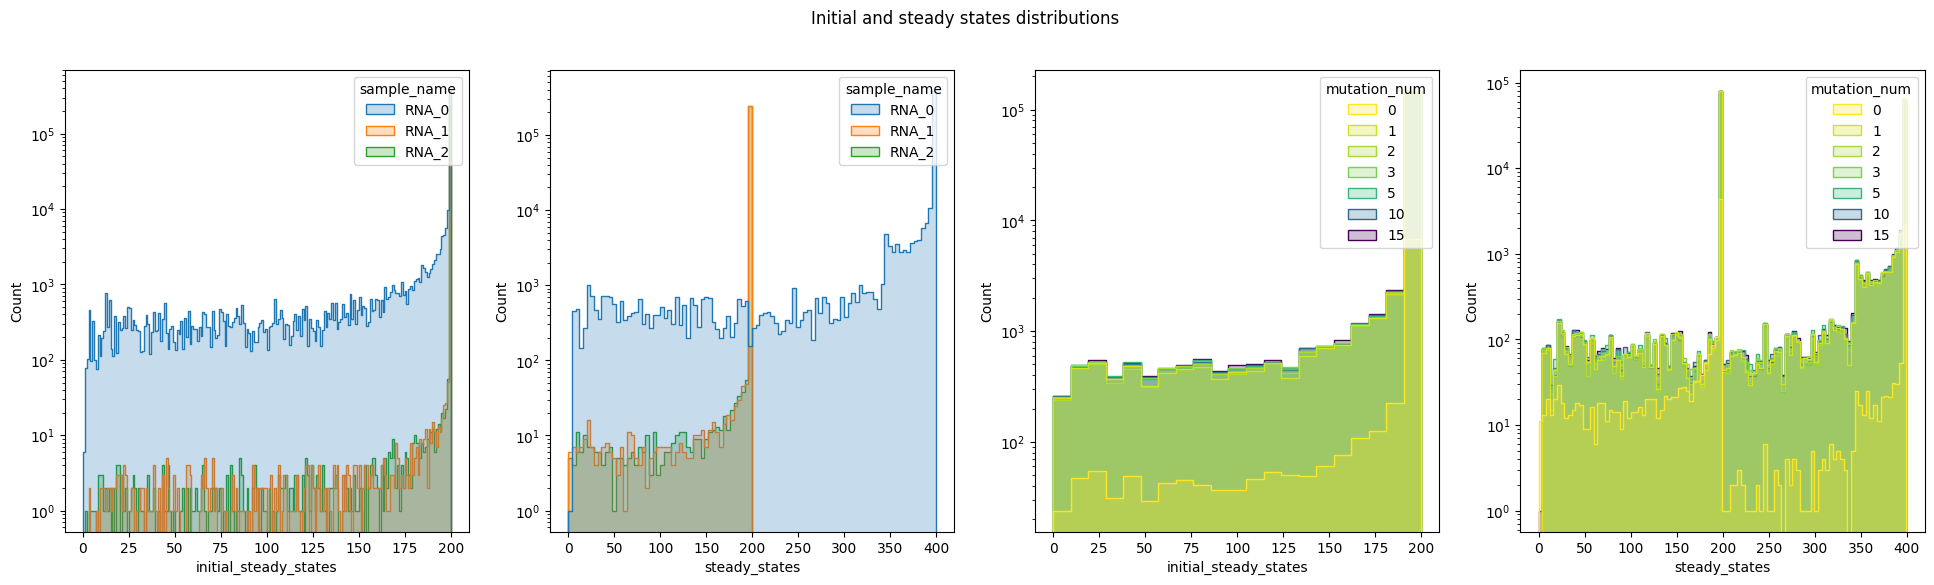

In [ ]:
plt.figure(figsize=(24,6))
ax = plt.subplot(1,4,1)
sns.histplot(choice_data, x='initial_steady_states', hue='sample_name', element='step', bins=200, log_scale=[False, True])

ax = plt.subplot(1,4,2)
sns.histplot(choice_data, x='steady_states', hue='sample_name', element='step', log_scale=[False, True])

ax = plt.subplot(1,4,3)
sns.histplot(choice_data, x='initial_steady_states', hue='mutation_num', element='step', log_scale=[False, True], palette='viridis_r')

ax = plt.subplot(1,4,4)
sns.histplot(choice_data, x='steady_states', hue='mutation_num', element='step', log_scale=[False, True], legend=True, palette='viridis_r')

plt.suptitle('Initial and steady states distributions')


Text(0.5, 0.98, 'Sensitivity vs. Fold change\nrelating to mode of sensitivity')

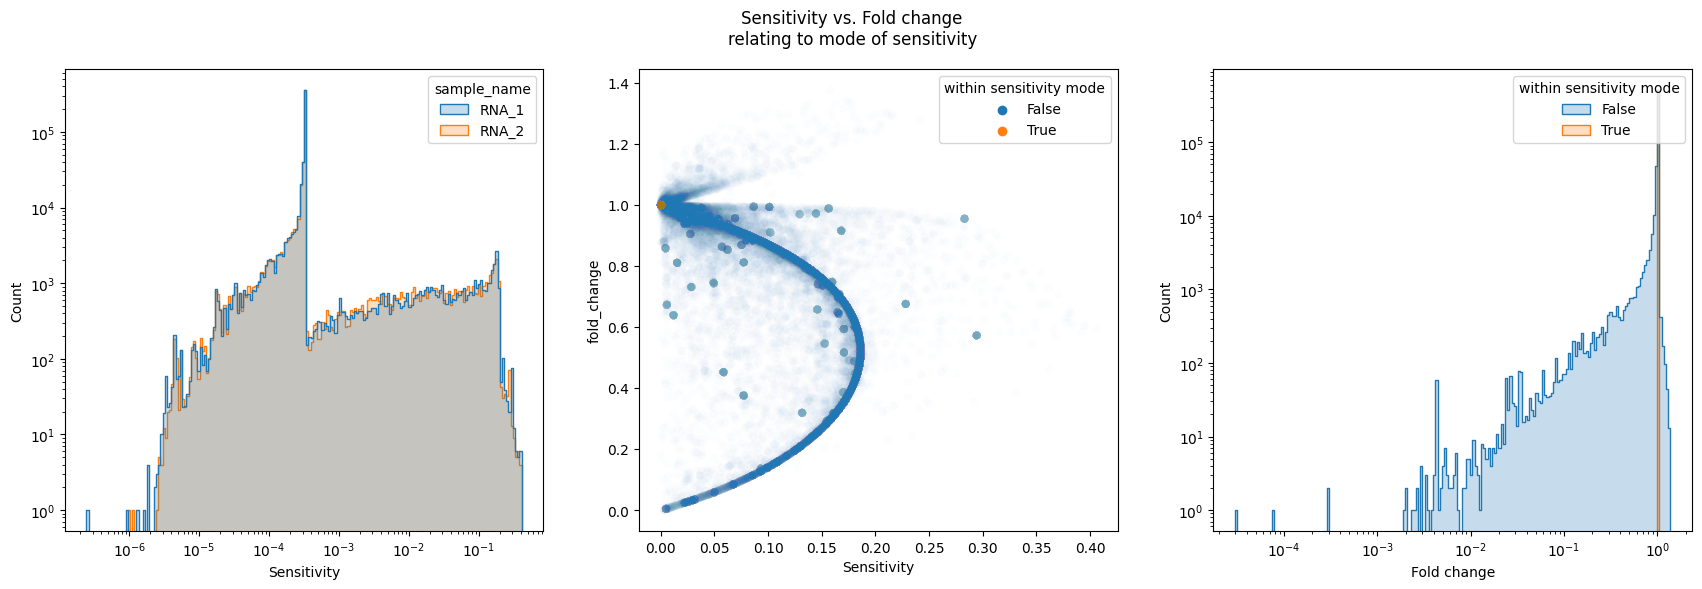

In [ ]:
plt.figure(figsize=(21,6))
ax = plt.subplot(1,3,1)
sns.histplot(data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')], x='sensitivity_wrt_species-6', 
             hue='sample_name', element='step', bins=200, log_scale=[True, True])
plt.xlabel('Sensitivity')

ax = plt.subplot(1,3,2)
sns.scatterplot(data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')], x='sensitivity_wrt_species-6', 
                y='fold_change', hue=data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')]['sensitivity_wrt_species-6'] == sensitivity_mode,
                alpha=0.01)
ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Sensitivity')

ax = plt.subplot(1,3,3)
sns.histplot(data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')], x='fold_change', 
             hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', bins=200, log_scale=[True, True])
ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Fold change')

plt.suptitle('Sensitivity vs. Fold change\nrelating to mode of sensitivity')


Text(0.5, 0.98, 'Initial and steady states relating to the mode of sensitivity')

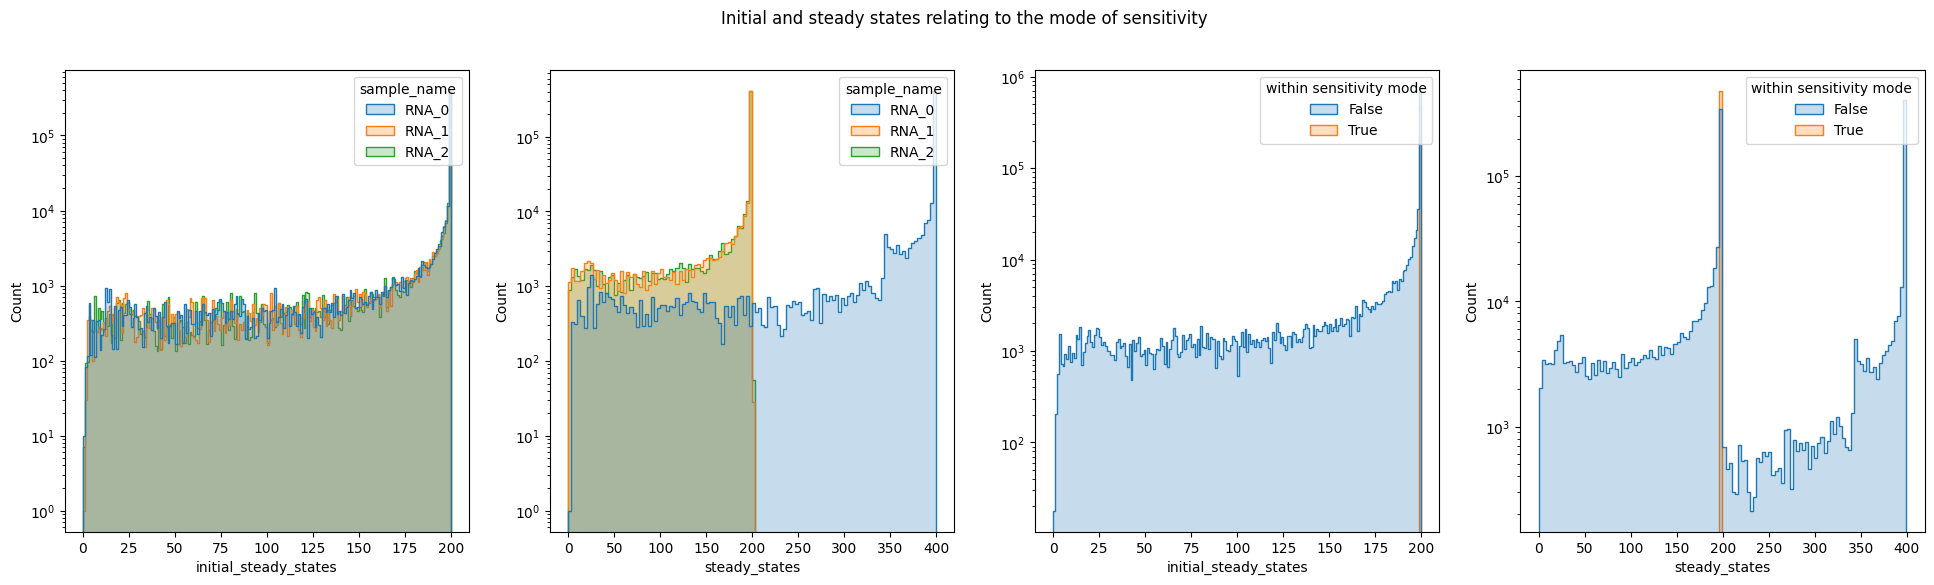

In [ ]:
plt.figure(figsize=(24,6))
ax = plt.subplot(1,4,1)
sns.histplot(data, x='initial_steady_states', hue='sample_name', element='step', bins=200, log_scale=[False, True])

ax = plt.subplot(1,4,2)
sns.histplot(data, x='steady_states', hue='sample_name', element='step', log_scale=[False, True])

ax = plt.subplot(1,4,3)
sns.histplot(x=data['initial_steady_states'], hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', bins=200, log_scale=[False, True])
ax.get_legend().set_title('within sensitivity mode')

ax = plt.subplot(1,4,4)
sns.histplot(x=data['steady_states'], hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', log_scale=[False, True], legend=True)
ax.get_legend().set_title('within sensitivity mode')

plt.suptitle('Initial and steady states relating to the mode of sensitivity')


Text(0.5, 1.0, 'Fold change relating to sensitivity mode')

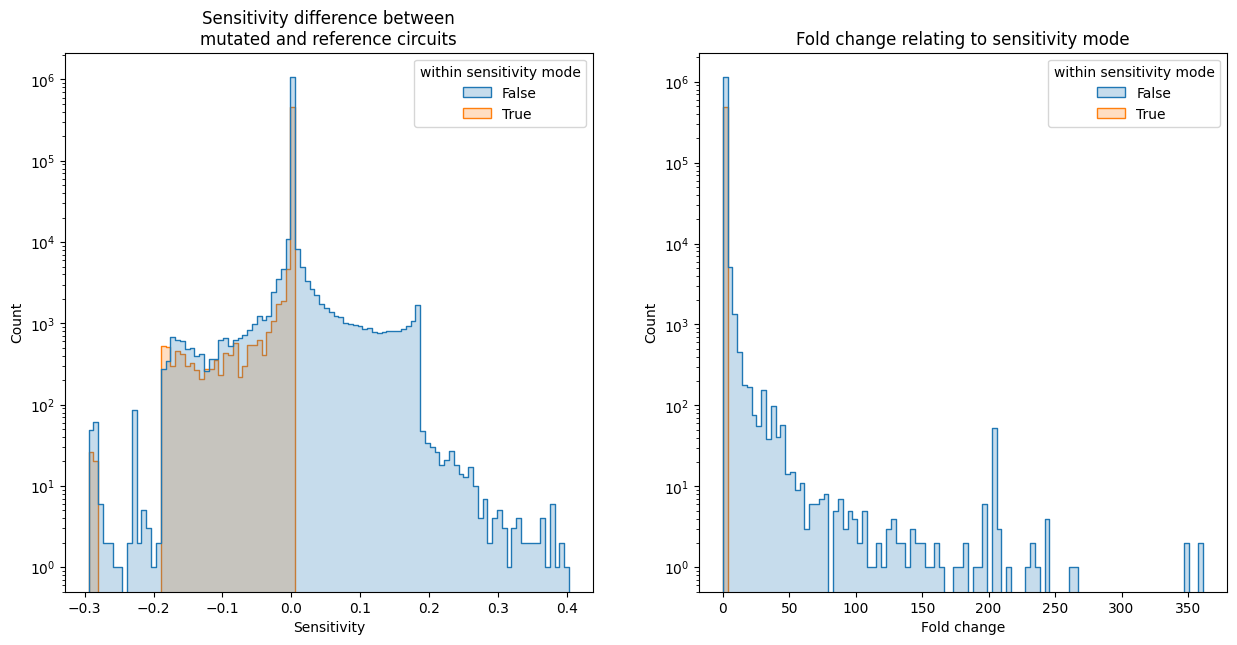

In [ ]:
plt.figure(figsize=(15,7))
ax = plt.subplot(1,2,1)
sns.histplot(x=data['sensitivity_wrt_species-6_diff_to_base_circuit'], hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', bins=100, log_scale=[False, True])
ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Sensitivity')
plt.title('Sensitivity difference between\nmutated and reference circuits')

ax = plt.subplot(1,2,2)
sns.histplot(x=data['fold_change'], hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', bins=100, log_scale=[False, True])
ax.get_legend().set_title('within sensitivity mode')
plt.xlabel('Fold change')
plt.title('Fold change relating to sensitivity mode')


In [ ]:
o2 = choice_data[choice_data['sample_name'] == 'RNA_1']['steady_states'] #.reset_index()
o1 = choice_data[choice_data['sample_name'] == 'RNA_1']['initial_steady_states'] #.reset_index()
i2 = choice_data[choice_data['sample_name'] == 'RNA_0']['steady_states'] #.reset_index()
i1 = choice_data[choice_data['sample_name'] == 'RNA_0']['initial_steady_states'] #.reset_index()

sens = ((o2 - o1) / o1).reset_index() / ((i2 - i1) / i1).reset_index()
sens

,index,0
0,1.333333,0.000629
1,1.166667,0.001873
2,1.111111,0.000623
3,1.083333,0.000091
4,1.066667,0.000542
...,...,...
51475,1.000002,-0.390293
51476,1.000002,-0.290887
51477,1.000002,-0.341942
51478,1.000002,-0.363375


## What should the sensitivity be?

In [73]:
data['circuit_id'] = list(map(lambda x: '-'.join(x), data[['circuit_name', 'mutation_name']].to_numpy()))
blip_circuits = data[data['sensitivity_wrt_species-6'] == sensitivity_mode]['circuit_id'].unique()

data[data['circuit_id'].isin(blip_circuits)][['max_amount', 'min_amount', 'initial_steady_states', 'steady_states', 'sample_name'] + get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]


,max_amount,min_amount,initial_steady_states,steady_states,sample_name,energies_0-0,energies_0-1,energies_0-2,energies_1-1,energies_1-2,energies_2-2
183,400.00000,199.73236,199.73236,399.46478,RNA_0,0.0,0.0,0.0,0.0,0.0,0.0
184,199.73236,199.66563,199.73236,199.66563,RNA_1,0.0,0.0,0.0,0.0,0.0,0.0
185,199.73236,199.66563,199.73236,199.66563,RNA_2,0.0,0.0,0.0,0.0,0.0,0.0
198,400.00000,199.73236,199.73236,399.46478,RNA_0,0.0,0.0,0.0,0.0,0.0,0.0
199,199.73236,199.66563,199.73236,199.66563,RNA_1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1628995,199.73236,199.66563,199.73236,199.66563,RNA_1,0.0,0.0,0.0,0.0,0.0,0.0
1628996,199.73236,199.66563,199.73236,199.66563,RNA_2,0.0,0.0,0.0,0.0,0.0,0.0
1628997,400.00000,199.73236,199.73236,399.46478,RNA_0,0.0,0.0,0.0,0.0,0.0,0.0
1628998,199.73236,199.66563,199.73236,199.66563,RNA_1,0.0,0.0,0.0,0.0,0.0,0.0


All the circuits that have this weird sensitivity value should actually have a sensitivity of 0 as they all have no interactions, but don't because of the fixed association rate. When there is no binding between two RNAs and their binding energy is estimated as zero, the equilibrium constant is 1, meaning that the dissociation rate is 1 / k_a. However, because k_a is non-zero, the k_d will have a non-infinity value, so there is somewhat more interaction than there should be.

Below is an example of how the sensitivity is calculated for such a null circuit and how the imperfect interaction simulation then .
The way to correct for this would be to set the sensitivity of all null circuits to zero for RNAs that are not the signalling RNA. 

In [62]:
from synbio_morpher.utils.results.analytics.timeseries import compute_sensitivity, compute_peaks

# data[data['circuit_id'].isin(blip_circuits[0])][['max_amount', 'min_amount', 'initial_steady_states', 'steady_states', 'sample_name']]
peaks = compute_peaks(*data[data['circuit_id'].isin([blip_circuits[0]])][['initial_steady_states', 'steady_states', 'max_amount', 'min_amount']].to_numpy().T)
starting_states=data[data['circuit_id'].isin([blip_circuits[0]])]['initial_steady_states'].to_numpy()
compute_sensitivity(signal_idx=0, starting_states=starting_states, peaks=peaks)

Array([1.0000000e+00, 3.3318755e-04, 3.3318755e-04], dtype=float32)

Text(0.5, 0, 'Ratio of steady state to initial state')

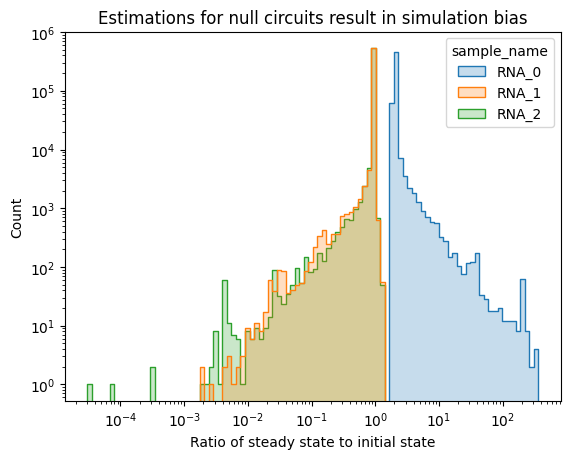

In [75]:
sns.histplot(x = data['steady_states'] / data['initial_steady_states'], hue=data['sample_name'], bins=100, log_scale=[True, True], element='step')
plt.title('Estimations for null circuits result in simulation bias')
plt.xlabel('Ratio of steady state to initial state')

In [82]:
data[data['sample_name'] != 'RNA_0'][(data['steady_states'] / data['initial_steady_states'])[data['sample_name'] != 'RNA_0'] > 1]['steady_states']
# [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]

188        198.461150
305        199.446040
509        189.540050
536        198.884500
887        191.372280
              ...    
1626505      7.647807
1626569     67.134770
1626661    192.548750
1626790    188.903230
1627097    135.256420
Name: steady_states, Length: 7367, dtype: float64